<a href="https://colab.research.google.com/github/HARSHGit45/100-days-of-DSA/blob/main/Semantic_Segmentation_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("quadeer15sh/augmented-forest-segmentation")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model

In [3]:
base_directory = '/root/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest Segmented/Forest Segmented'
images_folder = os.path.join(base_directory, 'images')
masks_folder = os.path.join(base_directory, 'masks')
data = pd.read_csv(os.path.join(base_directory, 'meta_data.csv'))

In [4]:
data.head()


,image,mask
0,10452_sat_08.jpg,10452_mask_08.jpg
1,10452_sat_18.jpg,10452_mask_18.jpg
2,111335_sat_00.jpg,111335_mask_00.jpg
3,111335_sat_01.jpg,111335_mask_01.jpg
4,111335_sat_02.jpg,111335_mask_02.jpg


In [5]:
img_dim = 256

image_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)
mask_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)

train_image_generator = image_datagen.flow_from_directory(
        '/root/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['images'],
        batch_size = 32,
        seed=42,
        subset='training')

train_mask_generator = mask_datagen.flow_from_directory(
        '/root/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = 32,
        seed=42,
        subset='training')

val_image_generator = image_datagen.flow_from_directory(
        '/root/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['images'],
        batch_size = 32,
        seed=42,
        subset='validation')

val_mask_generator = mask_datagen.flow_from_directory(
        '/root/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest Segmented/Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = 32,
        seed=42,
        subset='validation')


def create_combined_generator(image_gen, mask_gen):
    while True:
        image_batch = image_gen.__next__()
        mask_batch = mask_gen.__next__()
        yield (image_batch, mask_batch)

train_generator = create_combined_generator(train_image_generator, train_mask_generator)
val_generator = create_combined_generator(val_image_generator, val_mask_generator)

Found 4342 images belonging to 1 classes.
Found 4342 images belonging to 1 classes.
Found 766 images belonging to 1 classes.
Found 766 images belonging to 1 classes.


In [6]:
training_samples_size = train_image_generator.samples
val_samples_size = val_image_generator.samples

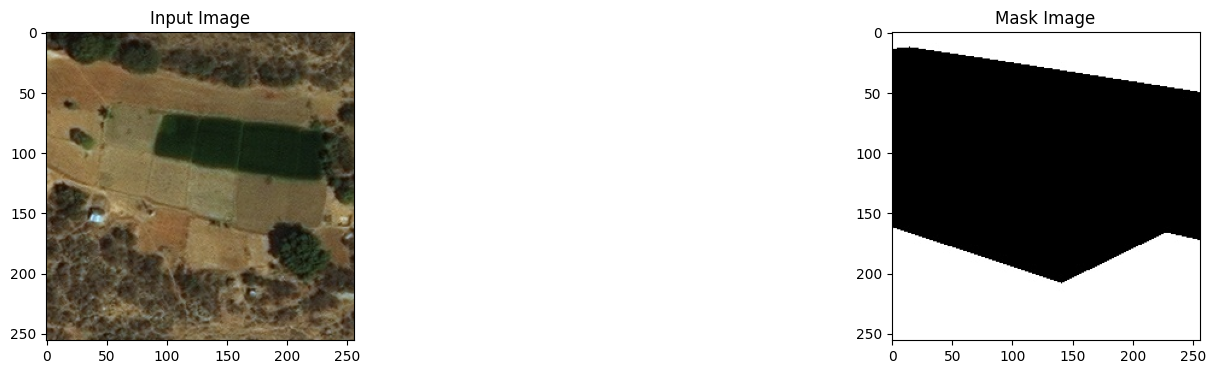

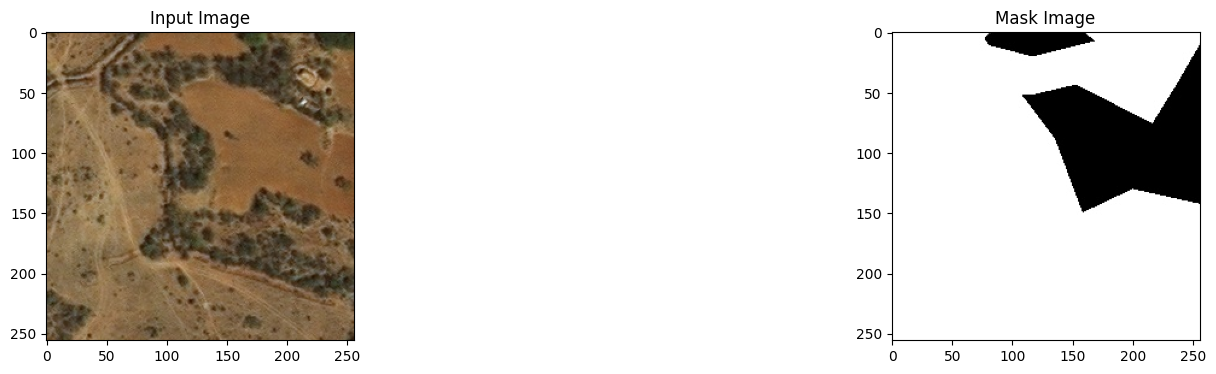

In [7]:
n = 0
for i,m in train_generator:
    img,mask = i,m

    if n < 2:
        fig, axs = plt.subplots(1 , 2, figsize=(20,4))
        axs[0].imshow(img[0])
        axs[0].set_title('Input Image')
        axs[1].imshow(mask[0],cmap='gray')
        axs[1].set_title('Mask Image')
        plt.show()
        n+=1
    else:
        break

In [8]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [9]:
input_shape = (img_dim, img_dim, 3)
model = build_unet(input_shape)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 64)   │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 64)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [10]:
model_path = "unet.h5"

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

In [13]:
history = model.fit(train_generator,
                    steps_per_epoch=training_samples_size//32,
                    validation_data=val_generator,
                    validation_steps=val_samples_size//32,
                    epochs=30)

Epoch 1/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 82s 609ms/step - accuracy: 0.8136 - loss: 0.3992 - val_accuracy: 0.7316 - val_loss: 0.5516
Epoch 2/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 82s 608ms/step - accuracy: 0.8129 - loss: 0.4016 - val_accuracy: 0.7838 - val_loss: 0.5901
Epoch 3/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 81s 601ms/step - accuracy: 0.8202 - loss: 0.3850 - val_accuracy: 0.6523 - val_loss: 0.6946
Epoch 4/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 81s 602ms/step - accuracy: 0.8234 - loss: 0.3801 - val_accuracy: 0.7747 - val_loss: 0.5052
Epoch 5/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 81s 602ms/step - accuracy: 0.8181 - loss: 0.3872 - val_accuracy: 0.7402 - val_loss: 0.5642
Epoch 6/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 81s 601ms/step - accuracy: 0.8210 - loss: 0.3868 - val_accuracy: 0.8052 - val_loss: 0.4629
Epoch 7/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 81s 601ms/step - accuracy: 0.8266 - loss: 0.3770 - val_accuracy: 0.7017 - val_loss: 0.6093
Epoch 8/30
135/135 ━━━━━━━━━━━━━━━━━━━━ 81s 601ms/step - accuracy: 0.8284 - loss: 0

In [14]:
model.save('segment.h5')

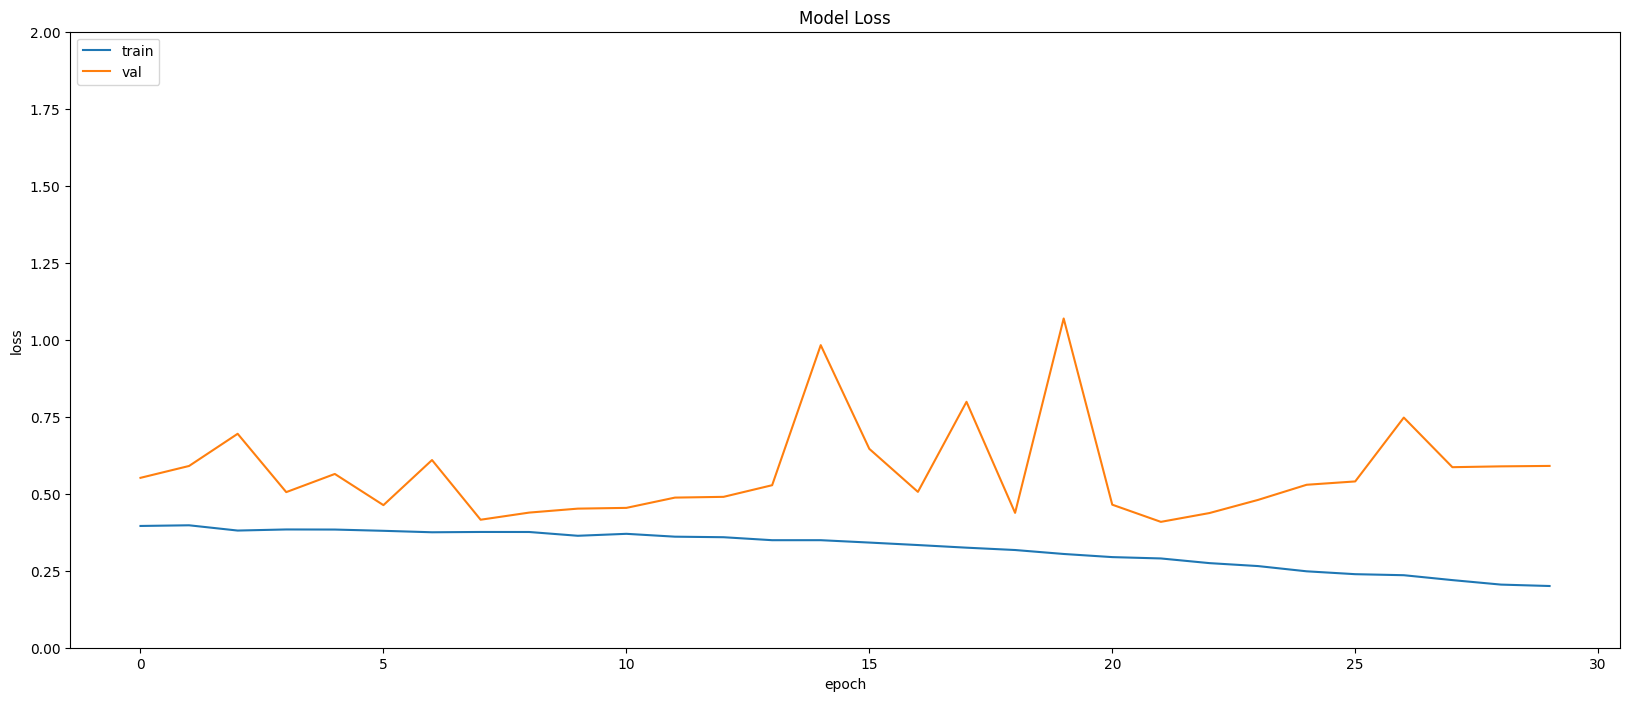

In [15]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,2])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
random_val_samples = val_generator.__next__()
val_image_samples = random_val_samples[0]
val_mask_samples = random_val_samples[1]
predicted_masks = model.predict(val_image_samples)

predicted_masks[predicted_masks >= 0.5] = 1
predicted_masks[predicted_masks < 0.5] = 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


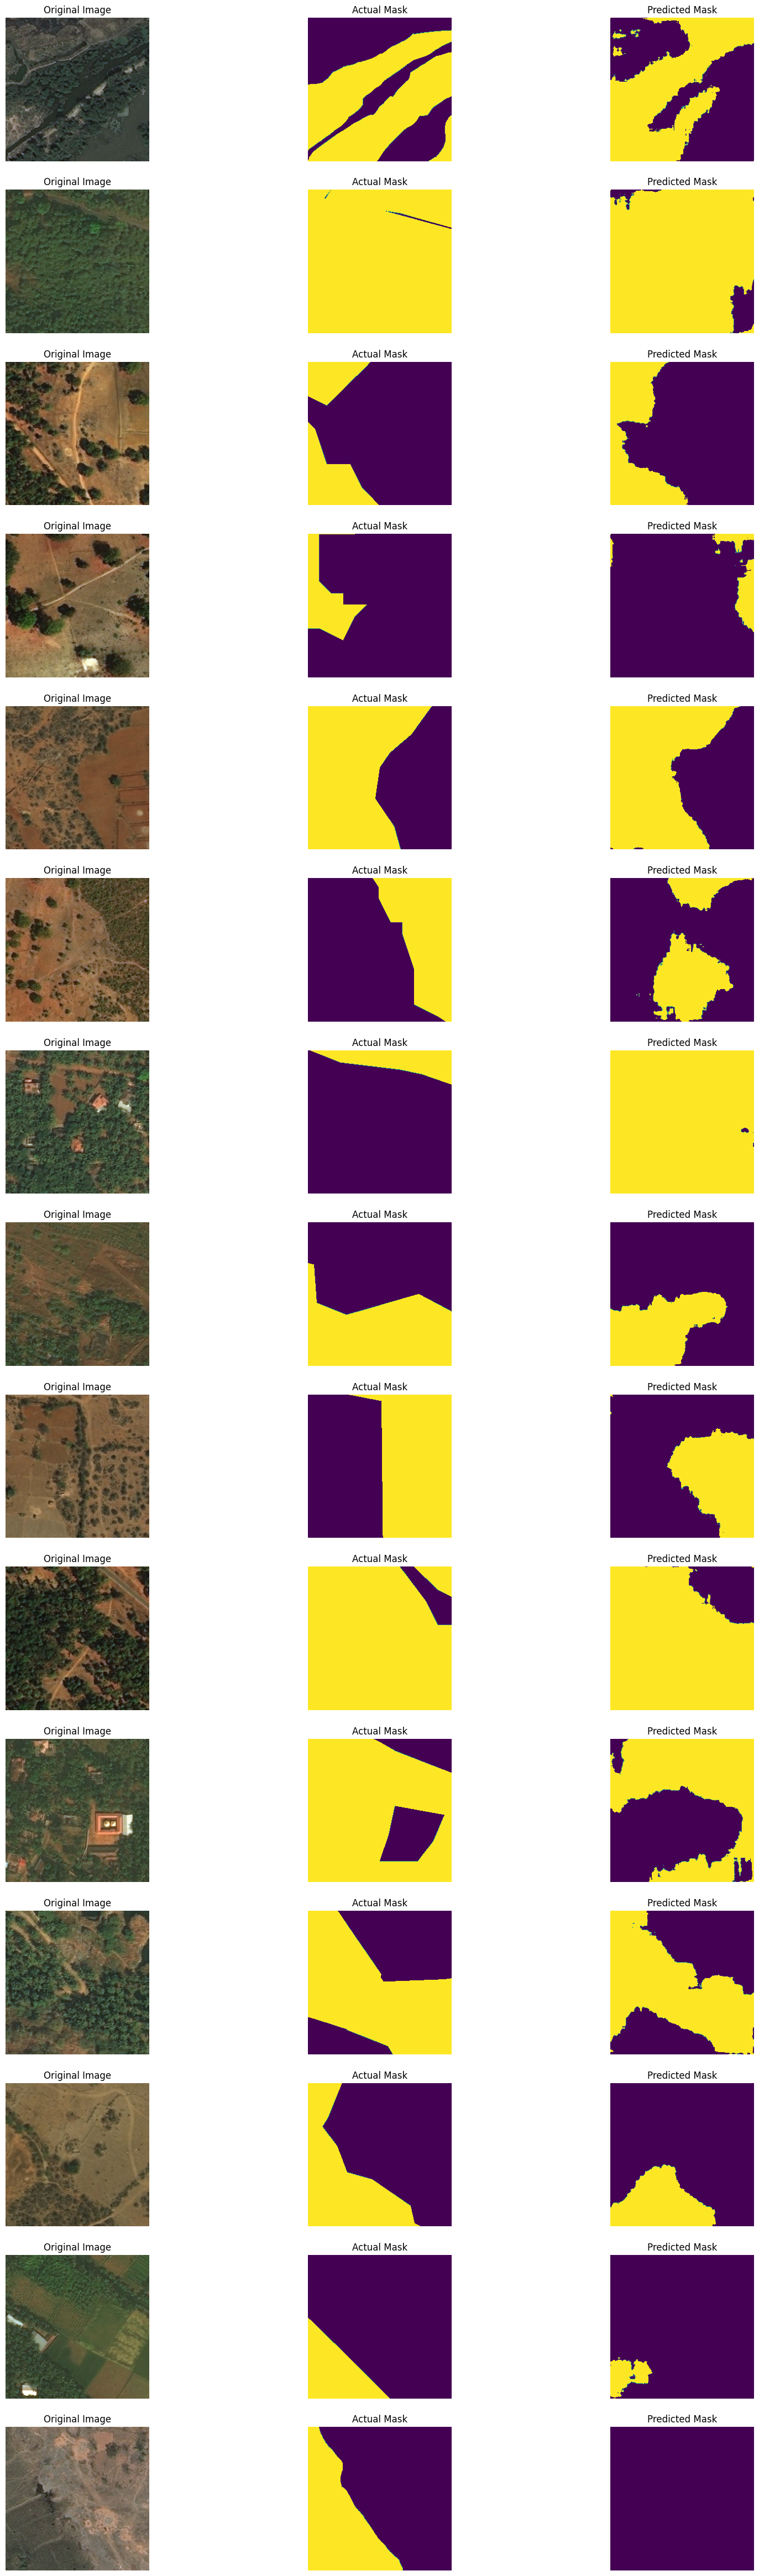

In [17]:
f, axarr = plt.subplots(15,3,figsize=(20, 60))

for i in range(0,15):

    axarr[i,0].imshow(val_image_samples[i])
    axarr[i,0].title.set_text('Original Image')
    axarr[i,0].axis('off')
    axarr[i,1].imshow(val_mask_samples[i])
    axarr[i,1].title.set_text('Actual Mask')
    axarr[i,1].axis('off')
    axarr[i,2].imshow(predicted_masks[i])
    axarr[i,2].title.set_text('Predicted Mask')
    axarr[i,2].axis('off')